# Parkinson's Disease Progression Prediction

## Pre-requisites

Import necessary libraries and mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn import model_selection
# from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Activation, Dropout


%matplotlib inline

In [3]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 67.8 MB/s eta 0:00:00


In [4]:
import tensorflow_decision_forests as tfdf

Load dataframes

In [5]:
df_train_clinical = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data analytics/parkinson/train_clinical_data.csv")
df_train_pep = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data analytics/parkinson/train_peptides.csv")
df_train_prot = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data analytics/parkinson/train_proteins.csv")

df_test_clinical = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data analytics/parkinson/example_test_files/test.csv")
df_test_pep = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data analytics/parkinson/example_test_files/test_peptides.csv")
df_test_prot = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data analytics/parkinson/example_test_files/test_proteins.csv")

## EDA

### Clinical Dataset

In [6]:
df_train_clinical.head(10)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
8,55_36,55,36,17.0,18.0,51.0,0.0,On
9,55_42,55,42,12.0,20.0,41.0,0.0,On


In [7]:
print("Train Clinical Information:")
print("----------------------------")
print(f"shape: {df_train_clinical.shape}")
print(f"unique values: {df_train_clinical['patient_id'].nunique()}")
print(f"Percentage of null values:\n{df_train_clinical.isna().sum() / df_train_clinical.shape[0] * 100.0}")

Train Clinical Information:
----------------------------
shape: (2615, 8)
unique values: 248
Percentage of null values:
visit_id                                0.000000
patient_id                              0.000000
visit_month                             0.000000
updrs_1                                 0.038241
updrs_2                                 0.076482
updrs_3                                 0.956023
updrs_4                                39.694073
upd23b_clinical_state_on_medication    50.745698
dtype: float64


### Peptide Dataset

In [8]:
df_train_pep.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [9]:
print("Train Peptide Information:")
print("----------------------------")
print(f"shape: {df_train_pep.shape}")
print(f"unique id values: {df_train_pep['patient_id'].nunique()}")
print(f"unique peptide values: {df_train_pep['Peptide'].nunique()}")
print(f"Number of null values:\n{df_train_pep.isna().sum() / df_train_clinical.shape[0] * 100.0}")

Train Peptide Information:
----------------------------
shape: (981834, 6)
unique id values: 248
unique peptide values: 968
Number of null values:
visit_id            0.0
visit_month         0.0
patient_id          0.0
UniProt             0.0
Peptide             0.0
PeptideAbundance    0.0
dtype: float64


### Protein Dataset

In [10]:
df_train_prot.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [11]:
print("Train Protein Information:")
print("----------------------------")
print(f"shape: {df_train_prot.shape}")
print(f"unique id values: {df_train_prot['patient_id'].nunique()}")
print(f"unique protein values: {df_train_prot['UniProt'].nunique()}")
print(f"Number of null values:\n{df_train_prot.isna().sum() / df_train_clinical.shape[0] * 100.0}")

Train Protein Information:
----------------------------
shape: (232741, 5)
unique id values: 248
unique protein values: 227
Number of null values:
visit_id       0.0
visit_month    0.0
patient_id     0.0
UniProt        0.0
NPX            0.0
dtype: float64


## UPDRS Score analysis

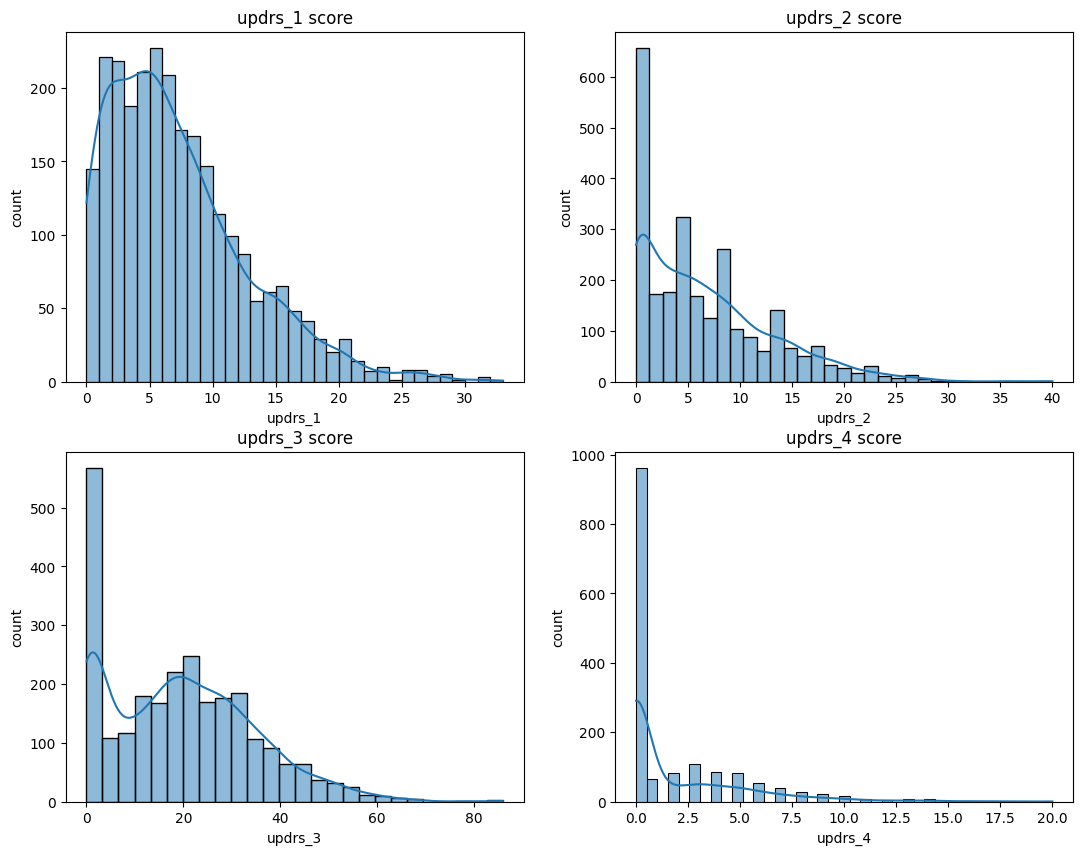

In [12]:
features = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(13, 10))
axs = axs.flatten()

for idx, feature in enumerate(features):
    ax = axs[idx]
    sns.histplot(x=df_train_clinical[feature], stat='count', kde = True, ax=ax)
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('count')
    ax.set_title(f'{feature} score')

**MDS-UPDRS** is a 4-part questionnaire that rates signs/symptoms (Parkinson's Disease). Score for each question 0 (normal) ~ 4 (most severe impairment) (maximum: 272 points)

* First level: Non-Motor Aspects of Experiences of Daily Living
* Second level: Motor Aspects of Experiences of Daily Living
* Third level: Motor Examination
* Fourth level: Motor Complications

Observations of the data:
* For levels 2, 3 and 4, the proportion of the symptoms are marked as normal is higher than more severe cases.
* For level 1, there is a wider range of severity

In [13]:
features = ['visit_month', 'NPX']
df_train_prot[features].agg({'visit_month':['count','min','max','median','mean','std'],
                              'NPX':['count','min','max','median','mean','std'],
                               }).transpose()

,count,min,max,median,mean,std
visit_month,232741.0,0.0000,108.0,24.0,2.609920e+01,2.287472e+01
NPX,232741.0,84.6082,613851000.0,113556.0,2.712077e+06,2.224155e+07


In [14]:
features = ['visit_month', 'PeptideAbundance']
df_train_pep[features].agg({'visit_month':['count','min','max','median','mean','std'],
                              'PeptideAbundance':['count','min','max','median','mean','std'],
                               }).transpose()

,count,min,max,median,mean,std
visit_month,981834.0,0.0000,108.0,24.0,26.105061,2.291390e+01
PeptideAbundance,981834.0,10.9985,178752000.0,74308.3,642890.245933,3.377989e+06


In [15]:
features = ['visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
df_train_clinical[features].agg({'visit_month':['count','min','max','median','mean','std'],
                              'updrs_1':['count','min','max','median','mean','std'],
                              'updrs_2':['count','min','max','median','mean','std'],
                              'updrs_3':['count','min','max','median','mean','std'],
                              'updrs_4':['count','min','max','median','mean','std']}).transpose()

,count,min,max,median,mean,std
visit_month,2615.0,0.0,108.0,24.0,31.190822,25.199053
updrs_1,2614.0,0.0,33.0,6.0,7.110559,5.525955
updrs_2,2613.0,0.0,40.0,5.0,6.743590,6.323230
updrs_3,2590.0,0.0,86.0,19.0,19.421236,15.000289
updrs_4,1577.0,0.0,20.0,0.0,1.861763,3.022112


Text(0.5, 1.0, 'Visit month count')

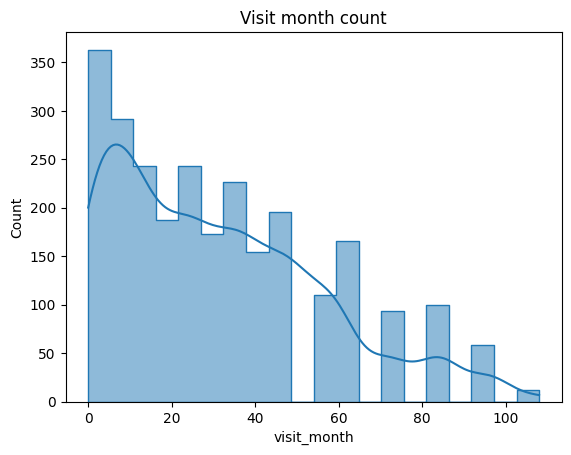

In [16]:
plt.figure()
sns.histplot(x=df_train_clinical['visit_month'], stat='count', kde = True, element='step')
plt.title('Visit month count')

Text(0.5, 1.0, 'Distribution of updrs_1 vs visit month')

<Figure size 640x480 with 0 Axes>

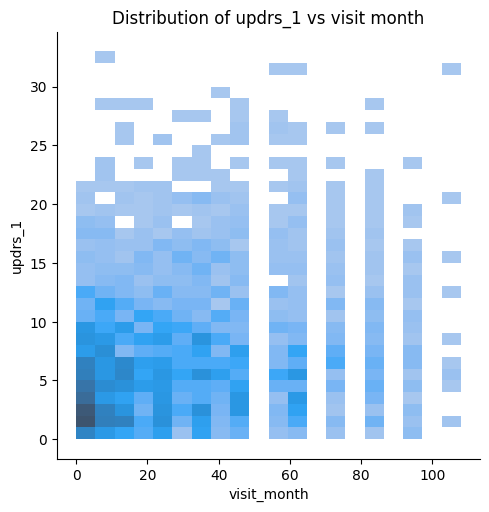

In [17]:
plt.figure()
sns.displot(x=df_train_clinical['visit_month'], y=df_train_clinical["updrs_1"])
plt.title('Distribution of updrs_1 vs visit month')

Text(0.5, 1.0, 'Distribution of updrs_2 vs visit month')

<Figure size 640x480 with 0 Axes>

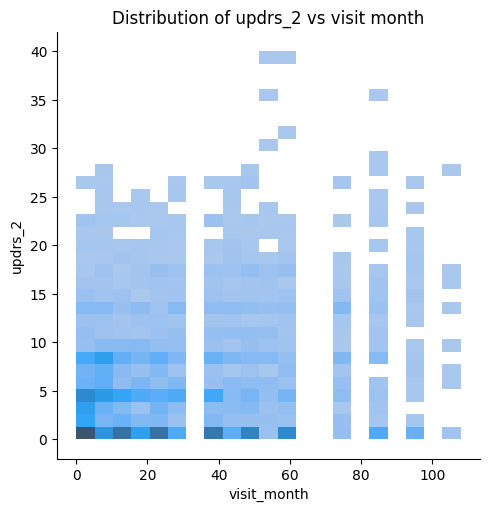

In [18]:
plt.figure()
sns.displot(x=df_train_clinical['visit_month'], y=df_train_clinical["updrs_2"])
plt.title('Distribution of updrs_2 vs visit month')

Text(0.5, 1.0, 'Distribution of updrs_3 vs visit month')

<Figure size 640x480 with 0 Axes>

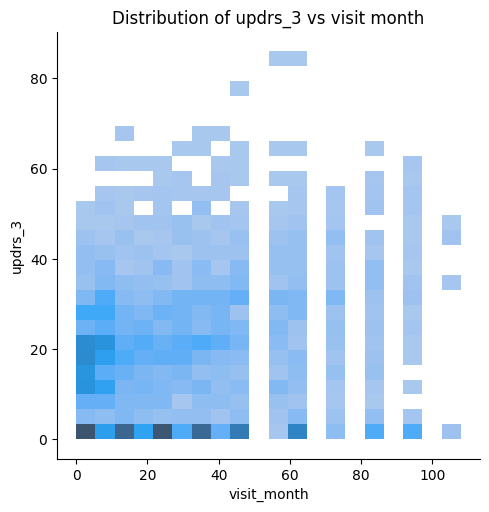

In [19]:
plt.figure()
sns.displot(x=df_train_clinical['visit_month'], y=df_train_clinical["updrs_3"])
plt.title('Distribution of updrs_3 vs visit month')

Text(0.5, 1.0, 'Distribution of updrs_4 vs visit month')

<Figure size 640x480 with 0 Axes>

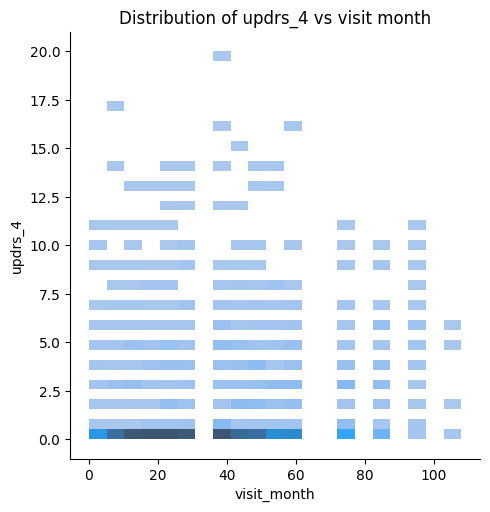

In [20]:
plt.figure()
sns.displot(x=df_train_clinical['visit_month'], y=df_train_clinical["updrs_4"])
plt.title('Distribution of updrs_4 vs visit month')

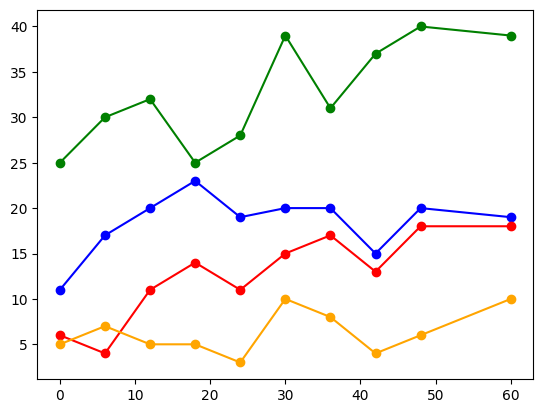

In [21]:
# Fetch data for patient with id 1517
plot_df = df_train_clinical[df_train_clinical["patient_id"]==1517]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")

In [22]:
tmp = df_train_clinical.groupby('visit_month').mean()[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]

<ipython-input-22-8270943d6b02>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df_train_clinical.groupby('visit_month').mean()[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]


In [23]:
df_train_clinical

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off


In [24]:
test = df_train_clinical.pivot(index='visit_month', columns='patient_id', values=['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'])

In [25]:
test.head()

updrs_1                                                        \
patient_id    55    942   1517  1923  2660  3636  3863  4161  4172  4923    
visit_month                                                                 
0              10.0   3.0  11.0   2.0   2.0   1.0   8.0   6.0   2.0   2.0   
3              10.0   7.0   NaN   NaN   NaN   4.0   NaN   1.0   NaN   NaN   
6               8.0   8.0  17.0   2.0   NaN  11.0   9.0   1.0   NaN   6.0   
9               8.0   NaN   NaN   NaN   NaN   8.0   NaN   3.0   NaN   NaN   
12             10.0   5.0  20.0   1.0   0.0   9.0  11.0   6.0   1.0   6.0   

             ... updrs_4                                                        
patient_id   ...   62329 62437 62723 62732 62792 63875 63889 64669 64674 65043  
visit_month  ...                                                                
0            ...     NaN   5.0   NaN   3.0   NaN   0.0   0.0   NaN   NaN   NaN  
3            ...     NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
6            ...     NaN   0.0   NaN   4.0   NaN   0.0   NaN   NaN   NaN   NaN  
9            ...     NaN   NaN   1.0   NaN   0.0   NaN   NaN   0.0   NaN   0.0  
12           ...     NaN   3.0   NaN   0.0   0.0   0.0   3.0   0.0   NaN   0.0  

[5 rows x 992 columns]

Text(0.5, 1.0, 'updrs score vs visit month')

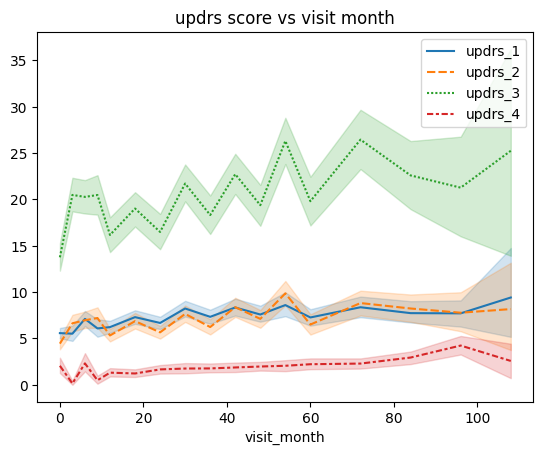

In [26]:
plt.figure()
sns.lineplot(test)
plt.title('updrs score vs visit month')

In [27]:
df_train_clinical.groupby('visit_month').mean()[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]

<ipython-input-27-74aed2476d2d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_train_clinical.groupby('visit_month').mean()[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]


,updrs_1,updrs_2,updrs_3,updrs_4
visit_month,,,,
0,5.572581,4.439516,13.754032,2.047619
3,5.513043,6.634783,20.482456,0.142857
6,7.109375,6.963542,20.272251,2.307692
9,6.080808,7.204082,20.474747,0.488372
12,6.222222,5.320988,16.165975,1.308271
18,7.299465,6.866310,19.016216,1.218978
24,6.670782,5.658436,16.489540,1.658065
30,8.231214,7.647399,21.710983,1.753425
36,7.331858,6.230088,18.316964,1.765432


In [28]:
df_train_prot

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0
...,...,...,...,...,...
232736,58648_108,108,58648,Q9UBX5,27387.8
232737,58648_108,108,58648,Q9UHG2,369437.0
232738,58648_108,108,58648,Q9UKV8,105830.0
232739,58648_108,108,58648,Q9Y646,21257.6


In [29]:
df_clinical_and_prot = df_train_clinical.merge(df_train_prot, on=['visit_id', 'visit_month', 'patient_id'])

In [30]:
df_clinical_and_prot.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,UniProt,NPX
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,O00391,11254.3
1,55_0,55,0,10.0,6.0,15.0,NaN,NaN,O00533,732430.0
2,55_0,55,0,10.0,6.0,15.0,NaN,NaN,O00584,39585.8
3,55_0,55,0,10.0,6.0,15.0,NaN,NaN,O14498,41526.9
4,55_0,55,0,10.0,6.0,15.0,NaN,NaN,O14773,31238.0


In [31]:
df_corr = df_clinical_and_prot[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'NPX', 'UniProt', 'visit_month']]

<ipython-input-32-ae2ba212e66c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_corr.corr()


<Axes: >

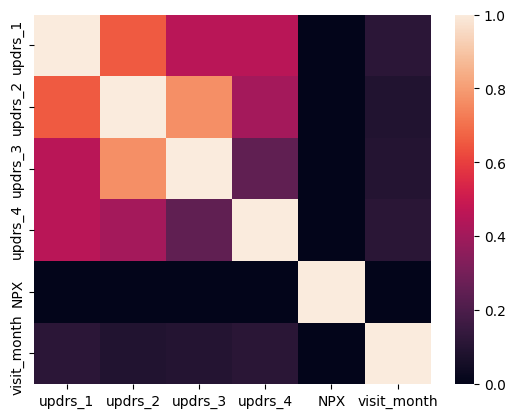

In [32]:
corr = df_corr.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [33]:
import matplotlib.pylab as ticks

<ipython-input-34-13ce97b63a62>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'O00391'),
 Text(1, 0, 'O00533'),
 Text(2, 0, 'O00584'),
 Text(3, 0, 'O14498'),
 Text(4, 0, 'O14773'),
 Text(5, 0, 'O14791'),
 Text(6, 0, 'O15240'),
 Text(7, 0, 'O15394'),
 Text(8, 0, 'O43505'),
 Text(9, 0, 'O60888'),
 Text(10, 0, 'O75144'),
 Text(11, 0, 'O75326'),
 Text(12, 0, 'O94919'),
 Text(13, 0, 'P00441'),
 Text(14, 0, 'P00450'),
 Text(15, 0, 'P00734'),
 Text(16, 0, 'P00736'),
 Text(17, 0, 'P00738'),
 Text(18, 0, 'P00746'),
 Text(19, 0, 'P00747'),
 Text(20, 0, 'P00748'),
 Text(21, 0, 'P00751'),
 Text(22, 0, 'P01008'),
 Text(23, 0, 'P01009'),
 Text(24, 0, 'P01011'),
 Text(25, 0, 'P01019'),
 Text(26, 0, 'P01023'),
 Text(27, 0, 'P01024'),
 Text(28, 0, 'P01031'),
 Text(29, 0, 'P01033'),
 Text(30, 0, 'P01034'),
 Text(31, 0, 'P01042'),
 Text(32, 0, 'P01344'),
 Text(33, 0, 'P01591'),
 Text(34, 0, 'P01608'),
 Text(35, 0, 'P01621'),
 Text(36, 0, 'P01717'),
 Text(37, 0, 'P01780'),
 Text(38, 0, 'P01833'),
 Text(39, 0, 'P01834'),
 Text(40, 0, 'P01857'),
 Text(41, 0, 'P01859'),
 T

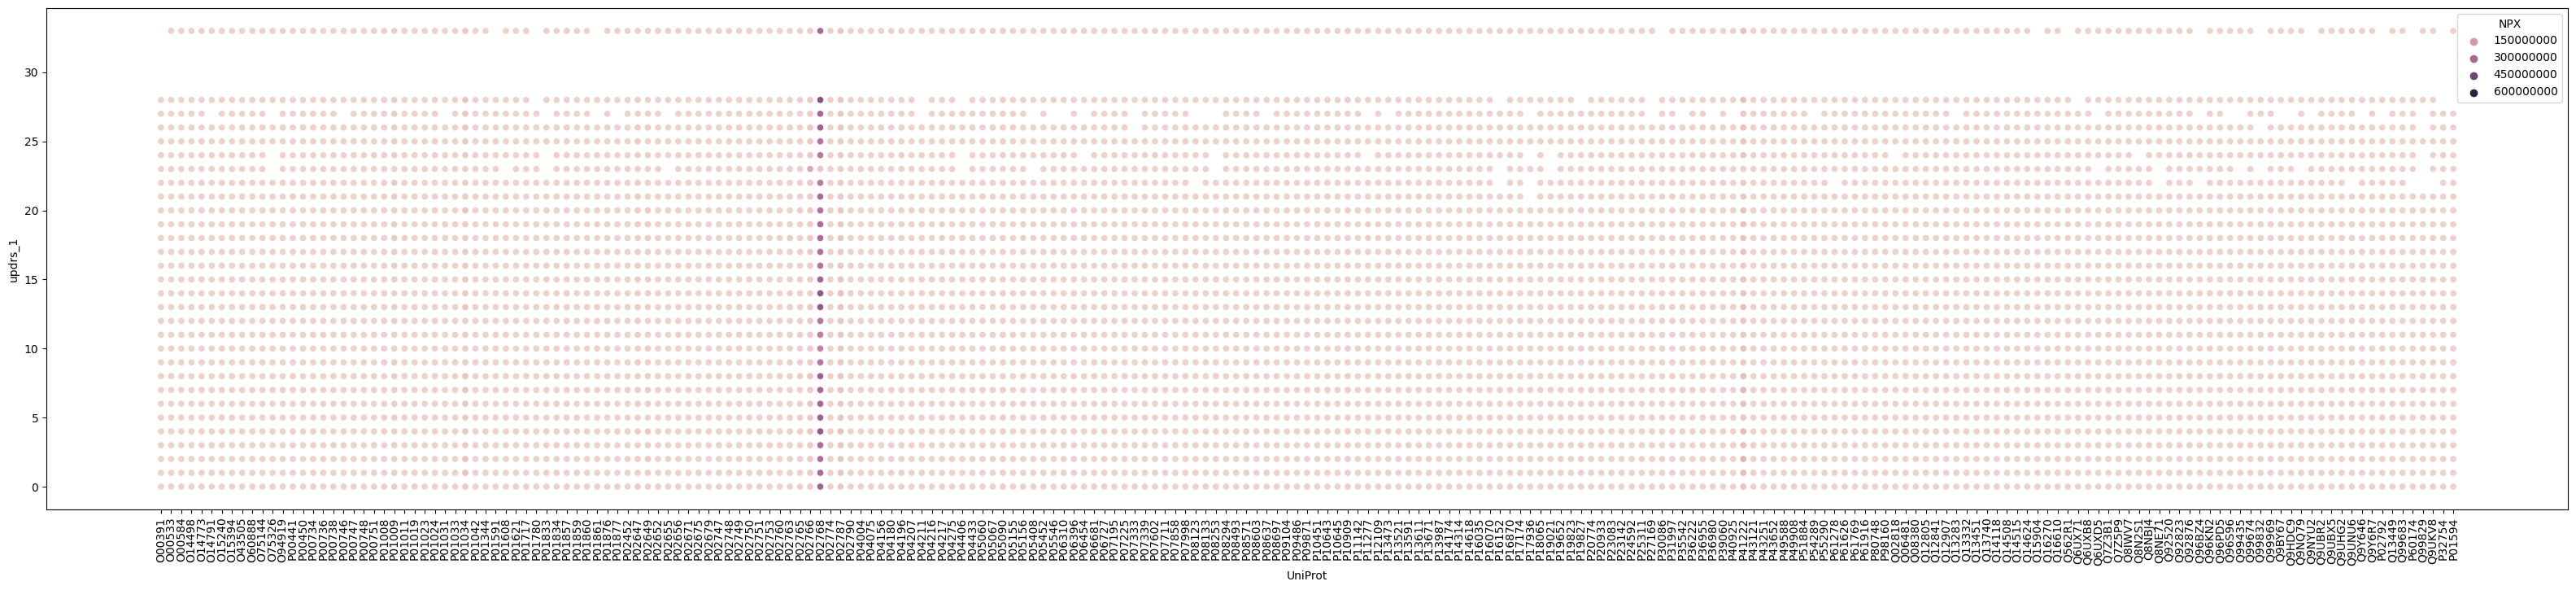

In [34]:
plt.figure(figsize=(40,8))
g = sns.scatterplot(data=df_clinical_and_prot, x='UniProt', y='updrs_1', hue='NPX')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

<ipython-input-35-0b480e762b6e>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'O00391'),
 Text(1, 0, 'O00533'),
 Text(2, 0, 'O00584'),
 Text(3, 0, 'O14498'),
 Text(4, 0, 'O14773'),
 Text(5, 0, 'O14791'),
 Text(6, 0, 'O15240'),
 Text(7, 0, 'O15394'),
 Text(8, 0, 'O43505'),
 Text(9, 0, 'O60888'),
 Text(10, 0, 'O75144'),
 Text(11, 0, 'O75326'),
 Text(12, 0, 'O94919'),
 Text(13, 0, 'P00441'),
 Text(14, 0, 'P00450'),
 Text(15, 0, 'P00734'),
 Text(16, 0, 'P00736'),
 Text(17, 0, 'P00738'),
 Text(18, 0, 'P00746'),
 Text(19, 0, 'P00747'),
 Text(20, 0, 'P00748'),
 Text(21, 0, 'P00751'),
 Text(22, 0, 'P01008'),
 Text(23, 0, 'P01009'),
 Text(24, 0, 'P01011'),
 Text(25, 0, 'P01019'),
 Text(26, 0, 'P01023'),
 Text(27, 0, 'P01024'),
 Text(28, 0, 'P01031'),
 Text(29, 0, 'P01033'),
 Text(30, 0, 'P01034'),
 Text(31, 0, 'P01042'),
 Text(32, 0, 'P01344'),
 Text(33, 0, 'P01591'),
 Text(34, 0, 'P01608'),
 Text(35, 0, 'P01621'),
 Text(36, 0, 'P01717'),
 Text(37, 0, 'P01780'),
 Text(38, 0, 'P01833'),
 Text(39, 0, 'P01834'),
 Text(40, 0, 'P01857'),
 Text(41, 0, 'P01859'),
 T

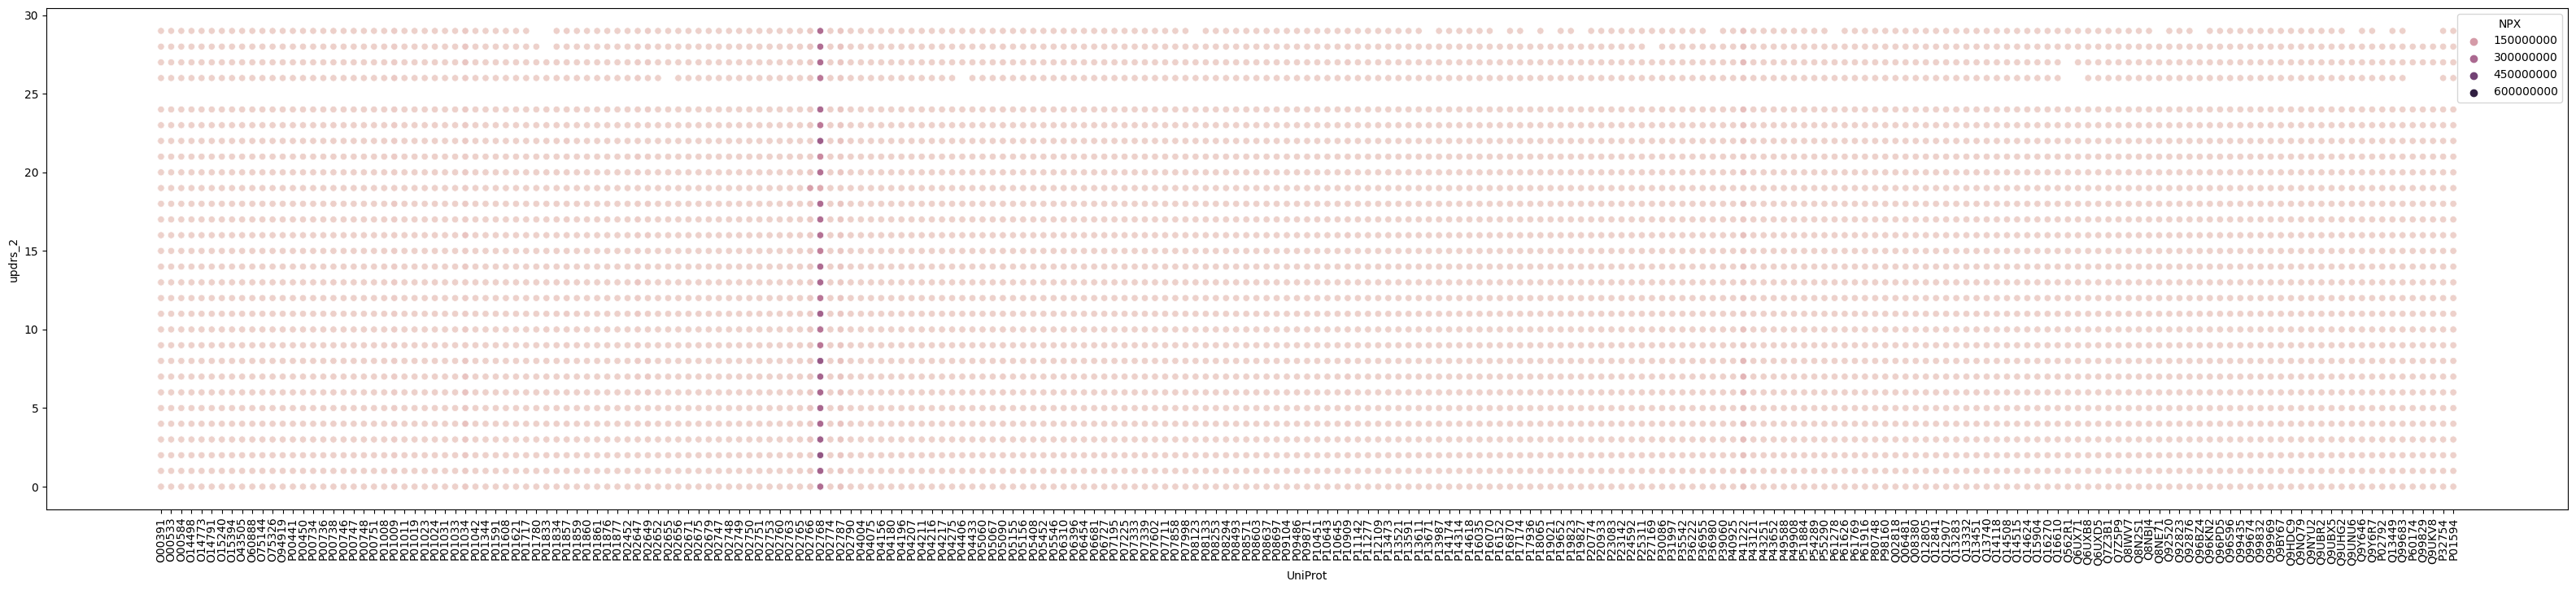

In [35]:
plt.figure(figsize=(40,8))
g = sns.scatterplot(data=df_clinical_and_prot, x='UniProt', y='updrs_2', hue='NPX')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

<ipython-input-36-86c5359ae122>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'O00391'),
 Text(1, 0, 'O00533'),
 Text(2, 0, 'O00584'),
 Text(3, 0, 'O14498'),
 Text(4, 0, 'O14773'),
 Text(5, 0, 'O14791'),
 Text(6, 0, 'O15240'),
 Text(7, 0, 'O15394'),
 Text(8, 0, 'O43505'),
 Text(9, 0, 'O60888'),
 Text(10, 0, 'O75144'),
 Text(11, 0, 'O75326'),
 Text(12, 0, 'O94919'),
 Text(13, 0, 'P00441'),
 Text(14, 0, 'P00450'),
 Text(15, 0, 'P00734'),
 Text(16, 0, 'P00736'),
 Text(17, 0, 'P00738'),
 Text(18, 0, 'P00746'),
 Text(19, 0, 'P00747'),
 Text(20, 0, 'P00748'),
 Text(21, 0, 'P00751'),
 Text(22, 0, 'P01008'),
 Text(23, 0, 'P01009'),
 Text(24, 0, 'P01011'),
 Text(25, 0, 'P01019'),
 Text(26, 0, 'P01023'),
 Text(27, 0, 'P01024'),
 Text(28, 0, 'P01031'),
 Text(29, 0, 'P01033'),
 Text(30, 0, 'P01034'),
 Text(31, 0, 'P01042'),
 Text(32, 0, 'P01344'),
 Text(33, 0, 'P01591'),
 Text(34, 0, 'P01608'),
 Text(35, 0, 'P01621'),
 Text(36, 0, 'P01717'),
 Text(37, 0, 'P01780'),
 Text(38, 0, 'P01833'),
 Text(39, 0, 'P01834'),
 Text(40, 0, 'P01857'),
 Text(41, 0, 'P01859'),
 T

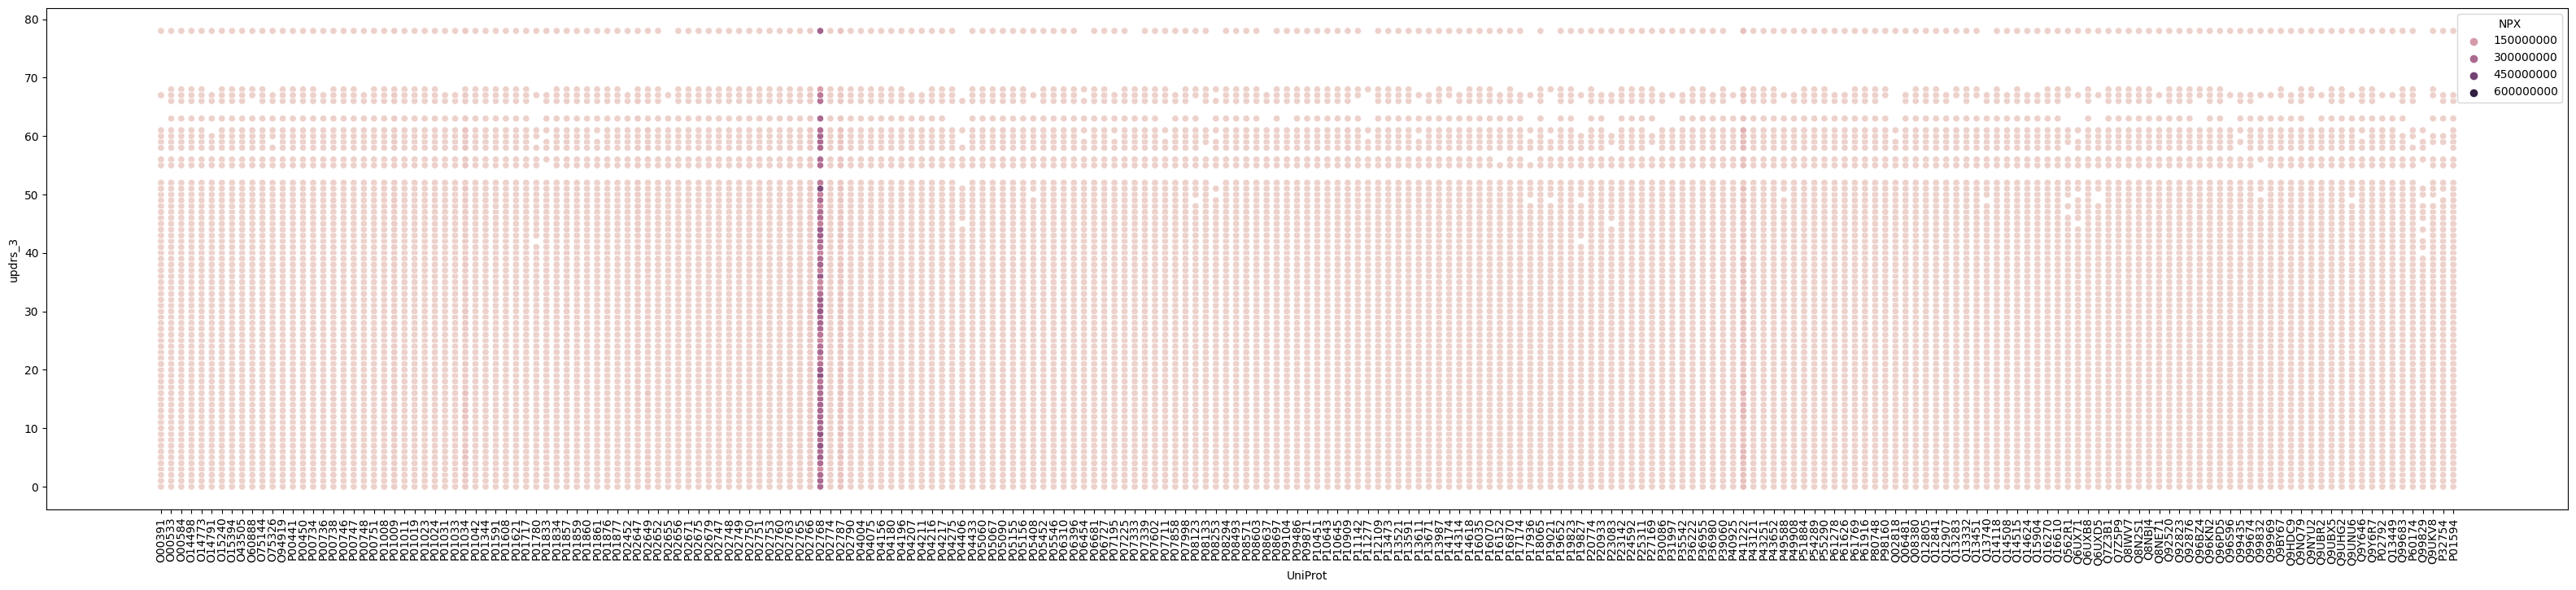

In [36]:
plt.figure(figsize=(40,8))
g = sns.scatterplot(data=df_clinical_and_prot, x='UniProt', y='updrs_3', hue='NPX')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

<ipython-input-37-e4b3acb6aac5>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'O00391'),
 Text(1, 0, 'O00533'),
 Text(2, 0, 'O00584'),
 Text(3, 0, 'O14498'),
 Text(4, 0, 'O14773'),
 Text(5, 0, 'O14791'),
 Text(6, 0, 'O15240'),
 Text(7, 0, 'O15394'),
 Text(8, 0, 'O43505'),
 Text(9, 0, 'O60888'),
 Text(10, 0, 'O75144'),
 Text(11, 0, 'O75326'),
 Text(12, 0, 'O94919'),
 Text(13, 0, 'P00441'),
 Text(14, 0, 'P00450'),
 Text(15, 0, 'P00734'),
 Text(16, 0, 'P00736'),
 Text(17, 0, 'P00738'),
 Text(18, 0, 'P00746'),
 Text(19, 0, 'P00747'),
 Text(20, 0, 'P00748'),
 Text(21, 0, 'P00751'),
 Text(22, 0, 'P01008'),
 Text(23, 0, 'P01009'),
 Text(24, 0, 'P01011'),
 Text(25, 0, 'P01019'),
 Text(26, 0, 'P01023'),
 Text(27, 0, 'P01024'),
 Text(28, 0, 'P01031'),
 Text(29, 0, 'P01033'),
 Text(30, 0, 'P01034'),
 Text(31, 0, 'P01042'),
 Text(32, 0, 'P01344'),
 Text(33, 0, 'P01591'),
 Text(34, 0, 'P01608'),
 Text(35, 0, 'P01621'),
 Text(36, 0, 'P01717'),
 Text(37, 0, 'P01780'),
 Text(38, 0, 'P01833'),
 Text(39, 0, 'P01834'),
 Text(40, 0, 'P01857'),
 Text(41, 0, 'P01859'),
 T

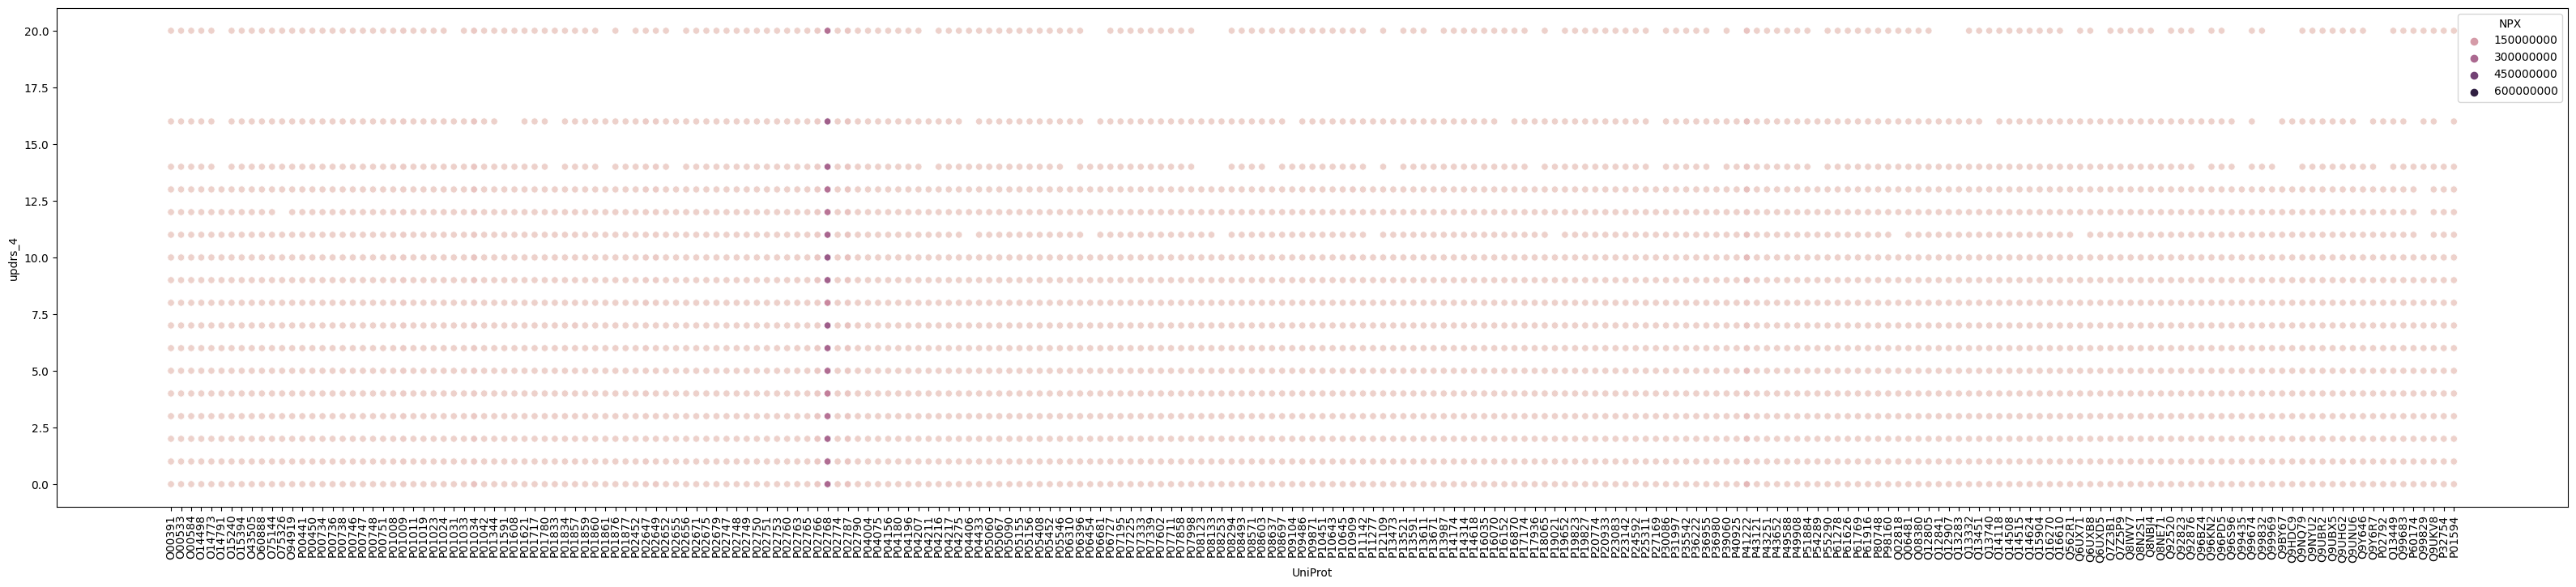

In [37]:
plt.figure(figsize=(40,8))
g = sns.scatterplot(data=df_clinical_and_prot, x='UniProt', y='updrs_4', hue='NPX')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

# Target preparation


In [38]:
# Create a dataset where rows are the visit_id and uniprot are the columns.
# Values on each cell correspond to the protein amount
df_protein = df_train_prot.pivot(index='visit_id', columns='UniProt', values='NPX').rename_axis(columns=None).reset_index()
df_protein.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,557904.0,44556.90,155619.0,14647.9,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,NaN,47836.70,177619.0,17061.1,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55


In [39]:
# Do the same for peptide level
df_pep = df_train_pep.pivot(index='visit_id', columns='Peptide', values='PeptideAbundance').rename_axis(columns=None).reset_index()
df_pep.head()

,visit_id,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,6580710.0,31204.4,7735070.0,NaN,NaN,NaN,46620.3,236144.0,NaN,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,6333510.0,52277.6,5394390.0,NaN,NaN,NaN,57554.5,108298.0,45885.4,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,7129640.0,61522.0,7011920.0,35984.7,17188.0,19787.3,36029.4,708729.0,5067790.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,7404780.0,46107.2,10610900.0,NaN,20910.2,66662.3,55253.9,79575.5,6201210.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,13788300.0,56910.3,6906160.0,13785.5,11004.2,63672.7,36819.8,34160.9,2117430.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [40]:
# Merge the two datasets
df_prot_pep = df_protein.merge(df_pep, on=['visit_id'], how='left')
df_prot_pep.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [41]:
df_prot_pep.describe()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
count,764.000000,1.112000e+03,1100.000000,1032.000000,1047.000000,942.000000,1113.000000,1050.000000,1110.000000,1079.000000,...,1100.000000,994.000000,1.022000e+03,977.000000,1.091000e+03,1111.000000,1089.000000,1105.000000,1030.000000,865.00000
mean,11641.264435,5.111649e+05,26505.529157,27305.934884,17688.295406,3004.990691,126151.780054,50773.474638,195599.363694,145382.047368,...,215246.833636,9015.134433,3.937256e+06,67866.452927,6.110779e+05,92581.223041,125937.993436,471554.596652,47068.709311,21072.04823
std,2817.003530,2.357357e+05,10705.152540,8446.187506,7166.325369,1142.159575,72748.393517,21382.028764,79739.704279,58028.089713,...,50727.227704,3127.061637,1.677710e+06,61176.002825,5.047422e+05,30138.957433,38696.448657,131150.715245,13689.667117,10360.59380
min,873.778000,5.971820e+04,591.103000,8945.340000,2811.120000,336.517000,10717.400000,5806.840000,29740.900000,8358.080000,...,12164.300000,258.249000,1.624640e+05,884.260000,7.494660e+03,869.898000,991.452000,11371.200000,6362.490000,868.90300
25%,9736.857500,3.490590e+05,19941.075000,21123.650000,12920.050000,2189.087500,70560.600000,37008.975000,142054.500000,103983.000000,...,186658.250000,6899.805000,2.895622e+06,30997.900000,2.929505e+05,70508.150000,100691.000000,384902.000000,37752.375000,14249.90000
50%,11546.400000,4.834425e+05,26529.700000,26624.000000,17399.600000,2865.460000,116900.000000,50375.800000,185616.000000,136452.000000,...,217430.500000,8604.345000,3.671010e+06,52576.900000,4.702450e+05,88918.600000,123588.000000,463382.000000,45503.150000,20390.90000
75%,13383.025000,6.485572e+05,33222.800000,32459.275000,22077.050000,3593.147500,164947.000000,63446.700000,239731.500000,177451.000000,...,246423.500000,10612.775000,4.710635e+06,85369.600000,7.592380e+05,110140.000000,149597.000000,549455.000000,54748.350000,27031.90000
max,21361.800000,1.806980e+06,66252.400000,65347.900000,49695.600000,9352.640000,538862.000000,137369.000000,766591.000000,427084.000000,...,409939.000000,27670.500000,1.385550e+07,712856.000000,3.984710e+06,251526.000000,264224.000000,948416.000000,107220.000000,70020.80000


In [42]:
df_prot_pep.shape

(1113, 1196)

In [43]:
def create_split(dataset, ratio=0.20):
  # Creates a split for validation and for training
  indices = np.random.rand(len(dataset)) < ratio

  return dataset[~indices], dataset[indices] 

# Evaluation of the first model: Random Forest

## Model

First, we will create storage variables that will save information of the model and the error

In [44]:
dict_model = {}
dict_mse = {}
dict_smape = {}
dict_mae = {}

Then, we will define the variables that will be used in our model.
Basically, we will use all the protein and peptide information, and the visit month to make the predictions

In [45]:
features = [i for i in df_prot_pep.columns if i not in ["visit_id"]]
features.append("visit_month")

task = tfdf.keras.Task.REGRESSION

Then, we will train a random forest for each of the target variables,
which are stored in `target`. A random forest regressor with the default configuration of 300 trees can be created with the `tfdf.keras.RandomForestModel` function. The default max depth is 16. Each tree will use all the defined variables.


In [46]:
# target labels
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

for label in target:
    tmp_features = features.copy()
    # Merge the protein and peptides dataset with the clinical using visit_id as variable to merge
    # dataset_df = df_prot_pep.merge(df_train_clinical[['visit_id', 'patient_id', 'visit_month', label]], on = ['visit_id'], how = 'left')
    train_df = df_prot_pep.merge(df_train_clinical[['visit_id', 'visit_month', label]], on = ['visit_id'], how = 'left')
    
    # Drop rows with no label information
    dataset_df = train_df.dropna(subset=[label])
    # Add the label column to the features list
    tmp_features.append(label)
    
    # Split into train and validation only with the variables contained in
    # tmp_features
    train_split, valid_split = create_split(dataset_df[tmp_features])
    print(f'{len(train_split)} samples for training; {len(valid_split)} samples for testing')
    
    # tfdf library requires to transform pandas df to tensorflow's df
    # which is useful when training neural networks with accelerators like GPUs and TPUs.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_split, label=label, task = tfdf.keras.Task.REGRESSION)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_split, label=label, task = tfdf.keras.Task.REGRESSION)
    
    # we will now create a random forest with default settings. 
    rf = tfdf.keras.RandomForestModel(task=task, verbose=0)
    rf.compile(metrics=["mse", "mae"])
    
    # train the model and store the model
    rf.fit(x=train_ds)
    dict_model[label] = rf

    # evaluate the trained model on the validation set
    inspector = rf.make_inspector()
    inspector.evaluation()
    evaluation = rf.evaluate(x=valid_ds,return_dict=True)
    dict_mse[label] = evaluation["mse"]  
    dict_mae[label] = evaluation["mae"]  
    
    # Use the trained model to make predictions on the validation dataset.
    # Using these predictions, calculate and store the sMAPE value for this model.
    preds = rf.predict(valid_ds)
    # smape_dict[label] = smape(valid_df[label].values.tolist(), preds.flatten())

828 samples for training; 240 samples for testing


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 2s 2s/step
851 samples for training; 217 samples for testing
1/1 [==============================] - 2s 2s/step
823 samples for training; 235 samples for testing


1/1 [==============================] - 5s 5s/step - loss: 0.0000e+00 - mse: 174.9498 - mae: 10.1954


1/1 [==============================] - 2s 2s/step
450 samples for training; 119 samples for testing
1/1 [==============================] - 3s 3s/step


In [47]:
for name, value in dict_mse.items():
  print(f"{name}: mse {value:.4f}")

print("\nAverage mse", sum(dict_mse.values())/4)

updrs_1: mse 25.8032
updrs_2: mse 33.6673
updrs_3: mse 174.9498
updrs_4: mse 6.6045

Average mse 60.25618326663971


In [48]:
for name, value in dict_mae.items():
  print(f"{name}: mae {value:.4f}")

print("\nAverage mae", sum(dict_mae.values())/4)

updrs_1: mae 3.6566
updrs_2: mae 4.4201
updrs_3: mae 10.1954
updrs_4: mae 2.1896

Average mae 5.115415871143341


In [49]:
# display an example of the first 5 leaves of the first three
tfdf.model_plotter.plot_model_in_colab(dict_model['updrs_1'], tree_idx=0, max_depth=5)

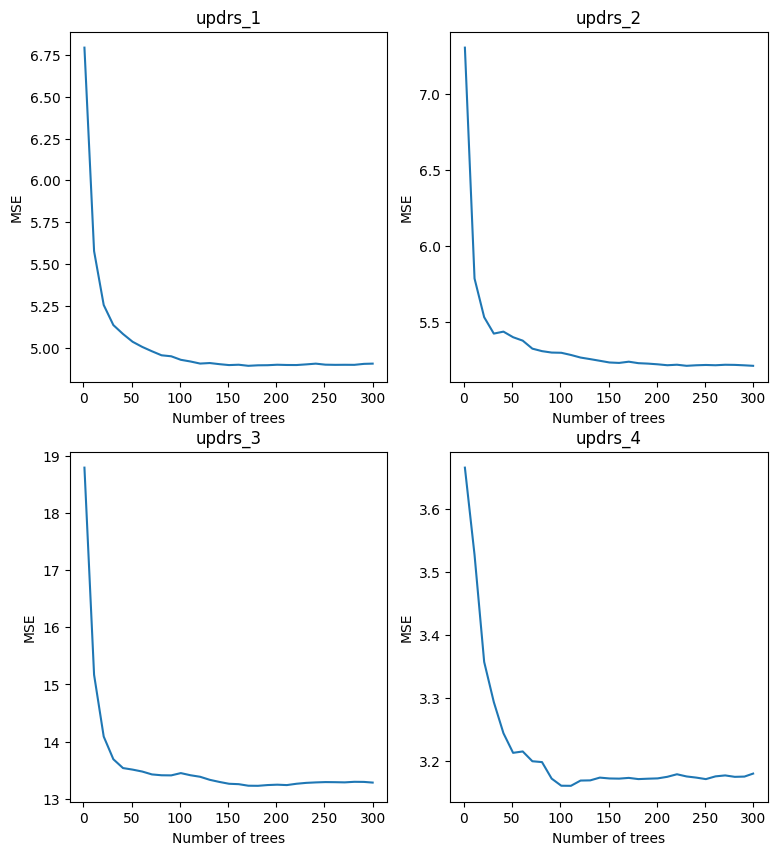

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(9,10))
axs = axs.flatten()

for idx, value in enumerate(target):
  logs = dict_model[value].make_inspector().training_logs()
  axs[idx].plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
  axs[idx].set_title(f'{value}')
  axs[idx].set_xlabel('Number of trees')
  axs[idx].set_ylabel('MSE')

We observe that the number of trees that are needed oscillates between 100. The reason may be because the dataset is small. Therefore, the number of trees can be reduced in fine-tuning to make faster the process.

## Variable Importance

The last step for this algorithm is to check which elements are the top-variables used for the creation of the trees.

updrs_1

In [51]:
inspector = dict_model['updrs_1'].make_inspector()
inspector.variable_importances()['NUM_AS_ROOT'][0:9]

[("Q06481" (1; #810), 42.0),
 ("P04180" (1; #703), 30.0),
 ("P05060" (1; #712), 20.0),
 ("P14618" (1; #760), 17.0),
 ("P07602" (1; #729), 12.0),
 ("QQTHMLDVMQDHFSR" (1; #888), 12.0),
 ("AATVGSLAGQPLQER" (1; #5), 10.0),
 ("P61916" (1; #801), 10.0),
 ("LEEQAQQIR" (1; #475), 9.0)]

**updrs_2**

In [52]:
inspector = dict_model['updrs_2'].make_inspector()
inspector.variable_importances()['NUM_AS_ROOT'][0:9]

[("Q06481" (1; #810), 45.0),
 ("P04180" (1; #703), 34.0),
 ("SSGLVSNAPGVQIR" (1; #988), 18.0),
 ("P10645" (1; #747), 17.0),
 ("O15240" (1; #635), 11.0),
 ("ISYGNDALMPSLTETK" (1; #395), 10.0),
 ("P05060" (1; #712), 10.0),
 ("SEALAVDGAGKPGAEEAQDPEGK" (1; #935), 10.0),
 ("Q92823" (1; #838), 9.0)]

**updrs_3**

In [53]:
inspector = dict_model['updrs_3'].make_inspector()
inspector.variable_importances()['NUM_AS_ROOT'][0:9]

[("DQGNQEQDPNISNGEEEEEKEPGEVGTHNDNQER" (1; #157), 27.0),
 ("ALEYIENLR" (1; #38), 22.0),
 ("P10645" (1; #747), 18.0),
 ("YPGPQAEGDSEGLSQGLVDREK" (1; #1181), 18.0),
 ("GEAGAPGEEDIQGPTK" (1; #280), 17.0),
 ("P13521" (1; #753), 17.0),
 ("O00533" (1; #630), 13.0),
 ("P02753" (1; #690), 11.0),
 ("O15240" (1; #635), 10.0)]

**updrs_4**

In [54]:
inspector = dict_model['updrs_4'].make_inspector()
inspector.variable_importances()['NUM_AS_ROOT'][0:9]

[("HLSLLTTLSNR" (1; #332), 28.0),
 ("LKC(UniMod_4)DEWSVNSVGK" (1; #501), 26.0),
 ("P05408" (1; #717), 18.0),
 ("P02656" (1; #681), 15.0),
 ("VSEADIQR" (1; #1133), 13.0),
 ("LMVELHNLYR" (1; #518), 10.0),
 ("GSPAINVAVHVFRK" (1; #314), 7.0),
 ("P00736" (1; #645), 7.0),
 ("QKVEPLRAELQEGAR" (1; #878), 7.0)]

In [55]:
df_test_protein = df_test_prot.pivot(index='visit_id', columns='UniProt', values='NPX').rename_axis(columns=None).reset_index()
df_test_peptide = df_test_pep.pivot(index='visit_id', columns='Peptide', values='PeptideAbundance').rename_axis(columns=None).reset_index()
df_test_prot_pep = df_test_protein.merge(df_test_peptide, on=['visit_id'], how='left')

In [56]:
df_test_prot_pep.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15031,O15240,O15394,...,YSSDYFQAPSDYR,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,3342_6,14564.0,616804.0,61418.1,27830.1,14959.2,2853.12,NaN,223373.0,58863.0,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
1,50423_0,33127.9,490742.0,43615.3,NaN,16486.6,2882.42,11963.7,124344.0,57688.1,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23


Adjust test dataset to match the columns used for training

In [57]:
# Remove columns that were not present on the original training set
common_columns = df_test_prot_pep.columns.intersection(df_prot_pep.columns)
df_test_prot_pep_filtered = df_test_prot_pep.copy(deep=True)
df_test_prot_pep_filtered = df_test_prot_pep_filtered[common_columns]

# Add missing columns
for col in features:
  if col not in df_test_prot_pep_filtered.columns:
    df_test_prot_pep_filtered[col] = 0

In [58]:
df_test_prot_pep_filtered.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,QQLVETHMAR,RYIETDPANRDR,SLEDQVEMLR,TINPAVDHC(UniMod_4)C(UniMod_4)K,TPVSDRVTK,TSPVDEKALQDQLVLVAAK,VAHQLQALR,VPEEDLKR,VSEADIQR,visit_month
0,3342_6,14564.0,616804.0,61418.1,27830.1,14959.2,2853.12,223373.0,58863.0,207497.0,...,0,0,0,0,0,0,0,0,0,0
1,50423_0,33127.9,490742.0,43615.3,NaN,16486.6,2882.42,124344.0,57688.1,200364.0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
def get_predictions(test_df, model_dict, features):

    # define target variables and make a copy of the test dataframe
    target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
    temp = test_df[features].copy()
    
    # remove variables that may cause potential errors
    mask = test_df[features].sum(axis=1) != 0
    new_test_df = temp.loc[mask]
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(new_test_df, task = tfdf.keras.Task.REGRESSION)
    
    for u in target:
        test_df['result_' + str(u)] = 0
        if u != 'updrs_4':
            print(f"predicting for model: {u}")
            # Predict a numeric value for the two test elements
            test_df.loc[mask, 'result_' + str(u)] = model_dict[u].predict(test_ds)
    
    # format required for kaggle
    result = pd.DataFrame()

    for m in [0, 6, 12, 24]:
        for u in [1, 2, 3, 4]:

            temp = test_df[["visit_id", "result_updrs_" + str(u)]].copy()
            temp["prediction_id"] = temp["visit_id"] + "_updrs_" + str(u) + "_plus_" + str(m) + "_months"
            temp["rating"] = temp["result_updrs_" + str(u)]
            temp = temp [['prediction_id', 'rating']]

            result = result.append(temp)            
    result = result.drop_duplicates(subset=['prediction_id', 'rating'])

    return result

In [61]:
df_test_prot_pep_filtered.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,QQLVETHMAR,RYIETDPANRDR,SLEDQVEMLR,TINPAVDHC(UniMod_4)C(UniMod_4)K,TPVSDRVTK,TSPVDEKALQDQLVLVAAK,VAHQLQALR,VPEEDLKR,VSEADIQR,visit_month
0,3342_6,14564.0,616804.0,61418.1,27830.1,14959.2,2853.12,223373.0,58863.0,207497.0,...,0,0,0,0,0,0,0,0,0,0
1,50423_0,33127.9,490742.0,43615.3,NaN,16486.6,2882.42,124344.0,57688.1,200364.0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df_test_prot_pep_filtered, task=task)
result = get_predictions(df_test_prot_pep_filtered, dict_model, features)
print(result)

predicting for model: updrs_1
1/1 [==============================] - 13s 13s/step
predicting for model: updrs_2
1/1 [==============================] - 10s 10s/step
predicting for model: updrs_3
1/1 [==============================] - 9s 9s/step
                    prediction_id     rating
0    3342_6_updrs_1_plus_0_months   5.157286
1   50423_0_updrs_1_plus_0_months   7.351326
0    3342_6_updrs_2_plus_0_months   4.201524
1   50423_0_updrs_2_plus_0_months   7.053487
0    3342_6_updrs_3_plus_0_months  16.406902
1   50423_0_updrs_3_plus_0_months  19.941156
0    3342_6_updrs_4_plus_0_months   0.000000
1   50423_0_updrs_4_plus_0_months   0.000000
0    3342_6_updrs_1_plus_6_months   5.157286
1   50423_0_updrs_1_plus_6_months   7.351326
0    3342_6_updrs_2_plus_6_months   4.201524
1   50423_0_updrs_2_plus_6_months   7.053487
0    3342_6_updrs_3_plus_6_months  16.406902
1   50423_0_updrs_3_plus_6_months  19.941156
0    3342_6_updrs_4_plus_6_months   0.000000
1   50423_0_updrs_4_plus_6_months   

<ipython-input-60-cd522f91e152>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
<ipython-input-60-cd522f91e152>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
<ipython-input-60-cd522f91e152>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
<ipython-input-60-cd522f91e152>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
<ipython-input-60-cd522f91e152>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)


We observe that we get the results for the two predicted variables, however, we cannot predict more than these values.

# Evaluation of the second model: Shallow Neural Network

For the second model, it is necessary to refactor target variables, so the rows correspond to the different visit id's, and each column will mark the updrs score at 0, 6, 12, 24 from the current exam.

In [63]:
# Create Targets
patients = {}
# iterate from updrs 1 to updsr 4
for e in range(1,5):
    # for months 0, 6, 12, and 24
    for m in [0, 6, 12, 24]:
        df_train_clinical[f'updrs_{e}_plus_{m}_months'] = 0

for patient in df_train_clinical.patient_id.unique():
    # Get all the entries per patient
    temp = df_train_clinical[df_train_clinical.patient_id == patient]
    month_list = []
    month_windows = [0, 6, 12, 24]
    # For each entry of visit month, create an entry at month, month+6, month+12 and month+24
    for month in temp.visit_month.values:
        month_list.append([month, month + 6, month + 12, month + 24])
    for month in range(len(month_list)):
        # if the visit month exists in the month list, copy the value
        for x in range(1, 5):
            arr = temp[temp.visit_month.isin(month_list[month])][f'updrs_{x}'].fillna(0).to_list()
            if len(arr) == 4:
                for e, i in enumerate(arr):
                    m = month_list[month][0]
                    temp.loc[temp.visit_month == m, [f'updrs_{x}_plus_{month_windows[e]}_months']] = i
            else:
                temp = temp[~temp.visit_month.isin(month_list[month])]
    patients[patient] = temp

Transform the output to a dataframe

In [64]:
formatted_clin = pd.concat(patients.values(), ignore_index=True).set_index('visit_id').iloc[:,7:].rename_axis(columns=None).reset_index()
formatted_clin

,visit_id,updrs_1_plus_0_months,updrs_1_plus_6_months,updrs_1_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_0_months,updrs_2_plus_6_months,updrs_2_plus_12_months,updrs_2_plus_24_months,updrs_3_plus_0_months,updrs_3_plus_6_months,updrs_3_plus_12_months,updrs_3_plus_24_months,updrs_4_plus_0_months,updrs_4_plus_6_months,updrs_4_plus_12_months,updrs_4_plus_24_months
0,55_0,10,8,10,16,6,10,10,9,15,34,41,49,0,0,0,0
1,55_6,8,10,7,14,10,10,13,13,34,41,38,49,0,0,0,0
2,55_12,10,7,16,17,10,13,9,18,41,38,49,51,0,0,0,0
3,55_18,7,16,14,12,13,9,13,20,38,49,49,41,0,0,0,0
4,55_24,16,14,17,17,9,13,18,16,49,49,51,52,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,65043_12,4,6,4,2,7,7,8,7,14,13,0,5,0,0,0,0
950,65043_18,6,4,3,9,7,8,4,10,13,0,4,15,0,0,0,0
951,65043_24,4,3,2,7,8,4,7,6,0,4,5,13,0,0,0,0
952,65043_30,3,2,9,4,4,7,10,8,4,5,15,11,0,0,0,1


In [65]:
df_merged_nn = df_prot_pep.merge(formatted_clin, on=['visit_id'], how='right')
df_merged_nn.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,updrs_2_plus_12_months,updrs_2_plus_24_months,updrs_3_plus_0_months,updrs_3_plus_6_months,updrs_3_plus_12_months,updrs_3_plus_24_months,updrs_4_plus_0_months,updrs_4_plus_6_months,updrs_4_plus_12_months,updrs_4_plus_24_months
0,55_0,11254.3,732430.0,39585.8,41526.9,31238.0,4202.71,177775.0,62898.2,333376.0,...,10,9,15,34,41,49,0,0,0,0
1,55_6,13163.6,630465.0,35220.8,41295.0,26219.9,4416.42,165638.0,62567.5,277833.0,...,13,13,34,41,38,49,0,0,0,0
2,55_12,15257.6,815083.0,41650.9,39763.3,30703.6,4343.60,151073.0,66963.1,332401.0,...,9,18,41,38,49,51,0,0,0,0
3,55_18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13,20,38,49,49,41,0,0,0,0
4,55_24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18,16,49,49,51,52,0,0,0,0


In [66]:
df_merged_nn.shape

(954, 1212)

In [67]:
print(f'\n Missing Values values: {df_merged_nn[df_merged_nn.columns].isna().sum().sum()/(len(df_merged_nn)*len(df_merged_nn.columns)):.2%}')


 Missing Values values: 53.20%


We have 53.20% of missing values. We will test our model filling those values with median

In [68]:
for column in df_merged_nn.columns:
    median = df_merged_nn[column].median()
    df_merged_nn[column].fillna(median, inplace=True)

In [69]:
print(f'\n Missing Values values: {df_merged_nn[df_merged_nn.columns].isna().sum().sum()/(len(df_merged_nn)*len(df_merged_nn.columns)):.2%}')


 Missing Values values: 0.00%


In [70]:
df_merged_nn.shape

(954, 1212)

Now, we must create a visit month variable since it is vital to know which month we got which results. We can do that by parsing information from the visit id column

In [71]:
df_merged_nn['visit_month'] = df_merged_nn.visit_id.str.split('_').apply(lambda x: int(x[1])).values

In [72]:
df_merged_nn.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,updrs_2_plus_24_months,updrs_3_plus_0_months,updrs_3_plus_6_months,updrs_3_plus_12_months,updrs_3_plus_24_months,updrs_4_plus_0_months,updrs_4_plus_6_months,updrs_4_plus_12_months,updrs_4_plus_24_months,visit_month
0,55_0,11254.3,732430.0,39585.8,41526.9,31238.0,4202.71,177775.0,62898.2,333376.0,...,9,15,34,41,49,0,0,0,0,0
1,55_6,13163.6,630465.0,35220.8,41295.0,26219.9,4416.42,165638.0,62567.5,277833.0,...,13,34,41,38,49,0,0,0,0,6
2,55_12,15257.6,815083.0,41650.9,39763.3,30703.6,4343.60,151073.0,66963.1,332401.0,...,18,41,38,49,51,0,0,0,0,12
3,55_18,11394.9,474223.5,26561.8,25957.3,17656.0,2875.12,112826.5,49292.5,186510.0,...,20,38,49,49,41,0,0,0,0,18
4,55_24,11394.9,474223.5,26561.8,25957.3,17656.0,2875.12,112826.5,49292.5,186510.0,...,16,49,49,51,52,0,0,0,0,24


In [73]:
X = df_merged_nn[df_prot_pep.columns.to_list() + ['visit_month']].set_index('visit_id')
y = df_merged_nn[formatted_clin.columns].drop('visit_id', axis=1)
print(f"X train shape: {X.shape}")
print(f"Y train shape: {y.shape}")

X train shape: (954, 1196)
Y train shape: (954, 16)


In [74]:
X

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,visit_month
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,11254.3,732430.0,39585.8,41526.9,31238.0,4202.71,177775.0,62898.2,333376.0,166850.0,...,16492.300,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.20,14898.40,0
55_6,13163.6,630465.0,35220.8,41295.0,26219.9,4416.42,165638.0,62567.5,277833.0,170345.0,...,13198.800,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.70,20703.90,6
55_12,15257.6,815083.0,41650.9,39763.3,30703.6,4343.60,151073.0,66963.1,332401.0,151194.0,...,17873.800,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.10,21841.10,12
55_18,11394.9,474223.5,26561.8,25957.3,17656.0,2875.12,112826.5,49292.5,186510.0,138259.0,...,8410.485,3575710.0,55933.5,494667.0,89357.9,121407.5,460454.0,44608.55,19647.45,18
55_24,11394.9,474223.5,26561.8,25957.3,17656.0,2875.12,112826.5,49292.5,186510.0,138259.0,...,8410.485,3575710.0,55933.5,494667.0,89357.9,121407.5,460454.0,44608.55,19647.45,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65043_12,14134.9,984651.0,28990.8,42440.9,25357.4,3267.66,270575.0,108246.0,321941.0,217877.0,...,16703.200,2481560.0,44405.0,543391.0,159828.0,161207.0,330337.0,45368.10,19023.20,12
65043_18,11394.9,474223.5,26561.8,25957.3,17656.0,2875.12,112826.5,49292.5,186510.0,138259.0,...,8410.485,3575710.0,55933.5,494667.0,89357.9,121407.5,460454.0,44608.55,19647.45,18
65043_24,14659.5,1062020.0,46440.4,38293.0,21971.8,3990.34,221358.0,117204.0,348672.0,175961.0,...,18326.200,2939460.0,50588.2,597869.0,148032.0,192857.0,388125.0,65101.00,20790.10,24


In [75]:
standard_scaler = StandardScaler()
X_scaled = pd.DataFrame(
      standard_scaler.fit_transform(X),
      columns=X.columns)

# Model

A shallow neural network has been proposed for this work

In [76]:
input_shape = [X_scaled.shape[1]]

model = tf.keras.Sequential()
model.add(Dense(64, input_shape = input_shape, activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(.5))
#model.add(Dense(150, activation = 'relu'))
#model.add(Dropout(.5))
model.add(Dense(y.shape[1]))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                76608     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 100)               6500      
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 16)                1

<Axes: >

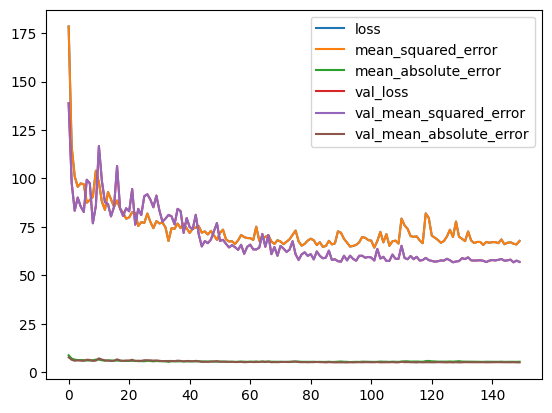

In [77]:
from keras.utils.vis_utils import plot_model

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['MeanSquaredError', 'MeanAbsoluteError',])

history = model.fit(
    X_scaled,
    y,
    epochs = 150,
    verbose = False,
    validation_split = .2
)
pd.DataFrame(history.history).plot()

In [78]:
history.history

{'loss': [178.3987579345703,
  116.35469818115234,
  101.10689544677734,
  95.73709106445312,
  97.43881225585938,
  97.01934051513672,
  87.52723693847656,
  88.89973449707031,
  90.49191284179688,
  104.027587890625,
  97.92627716064453,
  87.91195678710938,
  83.85747528076172,
  93.01107025146484,
  89.19232177734375,
  85.41754150390625,
  88.64230346679688,
  84.42245483398438,
  82.2875747680664,
  79.25305938720703,
  79.92278289794922,
  82.62104034423828,
  82.16889953613281,
  75.50595092773438,
  77.46569061279297,
  77.06314849853516,
  81.9155044555664,
  77.64273071289062,
  74.37944793701172,
  78.00724029541016,
  76.79589080810547,
  77.28425598144531,
  74.79266357421875,
  67.71831512451172,
  74.39225006103516,
  74.01741790771484,
  76.7520980834961,
  74.39909362792969,
  76.58236694335938,
  74.30919647216797,
  71.92059326171875,
  74.13216400146484,
  74.67967224121094,
  75.35240173339844,
  72.04657745361328,
  72.70775604248047,
  71.10608673095703,
  72.94

In [79]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [80]:
predictions = model.predict(X_scaled)
mean_squared_error(predictions, y)

30/30 [==============================] - 0s 3ms/step


63.019922619096505

In [81]:
mean_absolute_error(predictions, y)

5.282018263595846

In [ ]:
"""from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

X.visit_month = X.visit_month.astype('float')
y = y.astype('float')

feature_trans = ColumnTransformer([
    (
        'numerical',
        make_pipeline(IterativeImputer(), StandardScaler()),
        make_column_selector(dtype_include='number')
    ),
])

X_transformed = feature_trans.fit_transform(X)
"""

"from sklearn.preprocessing import OrdinalEncoder, StandardScaler\nfrom sklearn.compose import ColumnTransformer, make_column_selector\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\n\nX.visit_month = X.visit_month.astype('float')\ny = y.astype('float')\n\nfeature_trans = ColumnTransformer([\n    (\n        'numerical',\n        make_pipeline(IterativeImputer(), StandardScaler()),\n        make_column_selector(dtype_include='number')\n    ),\n])\n\nX_transformed = feature_trans.fit_transform(X)\n"

In [ ]:
import tensorflow.keras.backend as K

def smape_loss(y_true, y_pred):
    epsilon = 0.1
    numer = K.abs(y_pred - y_true)
    denom = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = numer / (denom/2)
    smape = tf.where(tf.math.is_nan(smape), tf.zeros_like(smape), smape)
    return smape


def calculate_smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    numer = np.round(np.abs(y_pred-y_true),0)
    denom = np.round(np.abs(y_true) + np.abs(y_pred),0)

    return 1/len(y_true) * np.sum(np.nan_to_num(numer / (denom/2))) *100